## **06. 사이킷런으로 수행하는 타이타닉 생존자 예측**
---

캐글: 오픈된 데이터 자료를 기반으로 전 세계 데이터 분석가가 데이터 분석 실력을 경쟁하고 협업하는 가장 뛰어난 데이터 분석 오픈 포탈

* 타이타닉 탑승자 데이터
    * Passengerid: 탑승자 데이터 일련번호
    * survived: 생존 여부, 0=사망, 1=생존
    * plcass: 티켓의 선실 등급, 1=일등석, 2=이등석, 3=삼등석
    * sex: 탑승자 성별
    * name: 탑승자 이름
    * Age: 탑승자 나이
    * sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
    * parch: 같이 탑승한 부모님 또는 어린이 인원수
    * ticket: 티켓 번호
    * fare: 요금
    * cabin: 선실 번호
    * embarked: 중간 정착 항구 C=Cherbourg, Q=Queenstown, S=Southampton

In [1]:
## 분석에 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 타이타닉 탑승자 파일 DataFrame으로 로딩
from google.colab import drive
drive.mount('/content/drive')

titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/titanic_train.csv')
titanic_df.head(3)

Mounted at /content/drive


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [2]:
## 데이터 칼럼 타입 확인
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


* **RangeIndex**: DataFrame 인덱스의 범위를 나타내 **전체 로우 수 파악 가능**
* 판다스의 object 타입은 string 타입으로 봐도 무방하다. 판다스는 넘파이 기반으로 만들어졌고 넘파이의 String 타입이 길이 제한이 있어 구분 위해 object 타입으로 명기한 것이다.
* Null값 확인 가능하다.  
.......
* ***Null 값을 어떻게 처리할지 결정*** 필요
    * DataFrame의 `fillna()` 함수를 사용해 Null 값을 평균 또는 고정 값으로 변경
        * 예: Age - 평균 나이, 나머지 칼럼 - 'N'값으로 변경 



In [3]:
## 모든 칼럼의 Null 값이 없는지 다시 확인
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수  0


* 남아있는 *문자열 피처 Sex, Cabin, Embarked의 값 분류*

In [4]:
print(' Sex 값 분포 :\n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


* Cabin(선실)의 경우 N이 687건으로 가장 많은 것도 특이하지만, 속성값이 제대로 정리가 되지 않아 보인다. 
    * 여러 Cabin이 한꺼번에 표기된 Cabin 값 존재 ex) 'C23 C25 C27'
    * 선실 번호 중 선실 등급을 나타내는 첫 번째 알파벳이 중요 -> *앞 문자만 추출*

In [5]:
## Cabin 속성에서 앞 문자만 추출
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


* **예측 수행 전 데이터 탐색**
    * 어떤 유형의 승객이 생존 확률이 높았는지 확인
        * 성별이 생존 확률에 어떤 영향을 미쳤는지, *성별에 따른 생존자 수를 비교*

In [6]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

* Survived 칼럼은 레이블로서 결정 클래스 값이다.
    * Survived 0: 사망, 1: 생존
    * 탑승객은 남자가 577명, 여자가 314명으로 남자가 더 많음
    * 여자는 약 74.2%가 생존했지만, 남자의 경우에는 약 18.8%가 생존  
......
* 성별에 따른 생존자 수를 비교    
    * *Seaborn 패키지를 이용해 시각화*
    * X축, Y축, 데이터 입력, `barplot()` 함수 호출

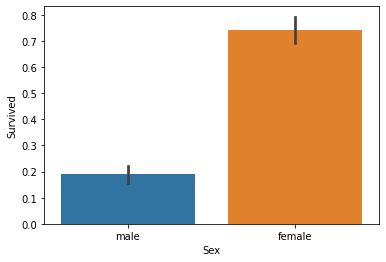

In [7]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

* 부자와 가난한 사람 간의 생존 확률 비교
    * 부를 측정할 수 있는 속성으로 적당한 것이 객실 등급
    * 일등실, 이등실, 삼등실에 따라 생존 확률 비교
* *객실 등급별 성별에 따른 생존 확률 표현*
    * `barplot()` 함수에 `hue` 파라미터 추가


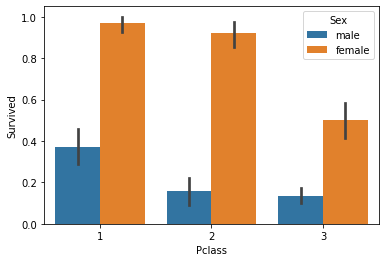

In [8]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

* 여성의 경우 일, 이등실에 따른 생존 확률의 차이는 크지 않으나, 삼등실의 경우 생존 확률이 상대적으로 많이 떨어짐을 알 수 있음
* 남성의 경우 일등실의 생존 확률이 이, 삼등실의 생존 확률보다 월등히 높음  
......
* *Age에 따른 생존 확률 알아보기*
    * 값 종류가 많으므로 범위별로 분류해 카테고리 값 할당
        * 0 ~ 5세는 Baby, 6 ~ 12세는 Child, 13 ~ 18세는 Teenager, 19 ~ 25세는 Student, 26 ~ 35세는 Young Adult, 36 ~ 60세는 Adult, 61세 이상은 Elderly로 분류
        * -1 이하의 오류 값은 Unknown으로 분류

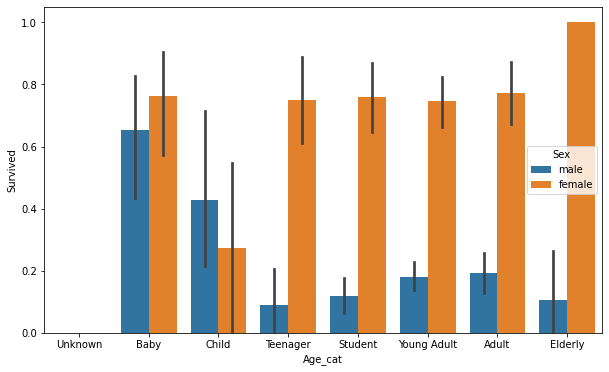

In [9]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'

    return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

# x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정
# get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

* 여자 Baby의 경우 비교적 생존 확률이 높다.
* 여자 Child의 경우는 다른 연령대에 비해 생존 확률이 낮다.
* 여자 Elderly의 경우는 매우 생존 확률이 높다.  
......
* ***남아있는 문자열 카테고리 Feature를 숫자형 카테고리 Feature로 변환***
    * 인코딩은 사이킷런의 `LabelEncoder` 클래스를 이용해 레이블 인코딩을 적용
        * `LabelEncoder` 객체는 카테고리 값의 유형 수에 따라 0 ~ (카테고리 유형 수-1) 까지의 숫자 값으로 변환
    * 사이킷런의 전처리 모듈의 대부분 인코딩 API는 사이킷런의 기본 프레임워크 API인 `fit()`, `transform()`으로 데이터를 변환
    * 여러 칼럼을 `encode_features()` 함수를 새로 생성해 한 번에 변환

In [10]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])

    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


* Sex, Cabin, Embarked 속성이 숫자형으로 바뀐 것을 알 수 있음  
......
* 지금까지 *Feature를 가공한 내역을 정리하고 이를 함수로 만들어 쉽게 재사용*할 수 있도록 만듦
    * `transform_features()`: 데이터의 전처리를 전체적으로 호출하는 함수
    * Null 처리, 포매팅, 인코딩을 수행하는 내부 함수로 구성

In [11]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

* *다시 원본 데이터를 가공*
    * 원본 CSV 파일을 다시 로딩
    * 타이타닉 생존자 데이터 세트의 레이블인 Survived 속성만 별도 분리해 클래스 결정값 데이터 세트로 만듦
    * Survived 속성을 드롭해 Feature 데이터 세트를 만듦
    * 생성된 Feature 데이터 세트에 `transform_features()`를 적용해 데이터를 가공

In [12]:
# 원본 데이터를 재로딩하고, Feature 데이터 세트와 레이블 데이터 세트 추출
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

* 내려받은 학습 데이터 세트를 기반으로 해서 `train_test_split()` API를 이용해 ***별도의 테스트 데이터 세트를 추출***
    * 테스트 데이터 세트 크기는 전체의 20%

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=11)

* ML 알고리즘인 **결정 트리, 랜덤 포레스트, 로지스틱 회귀를 이용**해 타이타닉 생존자 ***예측***
    * 결정 트리 - DecisionTreeClassifier 클래스
    * 랜덤 포레스트 - RandomForestClassifier 클래스
    * 로지스틱 회귀 - LogisticRegression 클래스
    * 사이킷런 클래스를 이용해 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습하고(fit), 예측(predict)할 것
        * 예측 성능 평가는 정확도로 하며, 이를 위해 `accuracy_score()` API를 사용
        * `random_state`는 실제 사례에서는 제거해도 무방

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [15]:
# 결정트리, Random Foreset, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForesetClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForesetClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForesetClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8492


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


* 3개의 알고리즘 중 LogisticRegression이 타 알고리즘에 비해 높은 정확도를 나타냄
* 아직 최적화 작업을 수행하지 않았고, 데이터 양도 충분하지 않기 때문에 어떤 알고리즘이 가장 성능이 좋다고 평가할 수는 없다.  
......
* ***교차 검증으로 결정 트리 모델을 좀 더 평가***
    * 교차 검증을 위한 사이킷런 model_selection 패키지의 `KFold` 클래스, `cross_val_score()`, `GridSearchCV` 클래스를 모두 사용
* *`KFold` 클래스를 이용해 교차 검증 수행*
    * 폴드 개수는 5개로 설정

In [16]:
## KFold 클래스를 이용해 교차 검증 수행, 폴드 개수는 5개로 설정
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold 객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []

    # KFold 교차 검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

    # 5개 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))
    
#exec_kfold 호출
exec_kfold(dt_clf, folds=5) 

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


* *`cross_val_score()` API를 이용해 교차 검증 수행*

In [17]:
## cross_val_score() API를 이용해 교차 검증 수행
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


* `cross_val_score()`가 StratifiedKFold를 이용해 폴드 세트를 분할하기 때문에 K 폴드의 평균 정확도가 약간 다름  
......
* *`GridSearchCV`를 이용해 `DecisionTreeClassifier`의 최적 하이퍼 파라미터 찾고 예측 성능 측정*
    * CV는 5개의 폴드 세트 지정
    * 하이퍼 파라미터는 `max_depth`, `min_samples_split`, `min_samples_leaf`를 변경하면서 성능 측정
    * 최적 하이퍼 파라미터와 그때의 예측 출력
    * 최적 하이퍼 파라미터로 학습된 Estimator를 이용해 위의 `train_test_split()`으로 분리된 테스트 데이터 세트에 예측을 수행해 예측 정확도 출력

In [18]:
## GridSearchCV를 이용해 DecisionTreeClassifier의 최적 하이퍼 파라미터 찾고 예측 성능 측정
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
              'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터: ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715


* 최적화된 하이퍼 파라미터인 `max_depth=3`, `min_samples_leaf=1`, `min_samples_split=2`로 `DecisionTreeClassifier`를 학습시킨 뒤 예측 정확도가 약 87.15%로 향상됨
* 하이퍼 파라미터 변경 전보다 약 8% 이상이 증가했는데 일반적으로 하이퍼 파라미터를 튜닝하더라도 이 정도 수준으로 증가하기는 매우 어렵다. 테스트용 데이터 세트가 작기 때문에 수치상으로 예측 성능이 많이 증가한 것처럼 보인다.

## **07. 정리**
---

* 머신러닝 애플리케이션은 **데이터의 가공 및 변환 과정의 전처리** 작업, 데이터를 **학습 데이터와 테스트 데이터로 분리**하는 데이터 세트 분리 작업을 거친 후에 학습 데이터를 기반으로 머신러닝 알고리즘을 적용해 **모델을 학습**시킨다.
    * 데이터의 전처리 작업: 오류 데이터의 보정이나 결손값(Null) 처리 등의 다양한 데이터 클렌징 작업, 레이블 인코딩이나 원-핫 인코딩과 같은 인코딩 작업, 그리고 데이터의 스케일링/정규화 작업 등으로 머신러닝 알고리즘이 최적으로 수행될 수 있게 데이터를 사전 처리하는 것
* 학습된 모델을 기반으로 **테스트 데이터에 대한 예측을 수행**하고, **예측된 결괏값을 실제 결괏값과 비교해 머신러닝 모델에 대한 평가를 수행**하는 방식으로 구성된다.
    * 머신러닝 모델은 학습 데이터 세트로 학습한 뒤 반드시 **별도의 테스트 데이터 세트로 평가**되어야 함.
    * 테스트 데이터의 건수 부족이나 고정된 테스트 데이터 세트를 이용한 반복적인 모델의 학습과 평가는 해당 테스트 데이터 세트에만 치우친 빈약한 머신러닝 모델을 만들 가능성이 높음
* 이를 해결하기 위해 학습 데이터 세트를 학습 데이터와 검증 데이터로 구성된 **여러 개의 폴드 세트로 분리해 교차 검증을 수행**할 수 있다.
    * 사이킷런은 이러한 교차 검증을 지원하기 위해 `KFold`, `StratifiedKFold`, `cross_val_score()` 등의 다양한 클래스와 함수를 제공
    * 머신러닝 모델의 최적의 하이퍼 파라미터를 교차 검증을 통해 추출하기 위해 `GridSearchCV`를 제공